In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from scipy import stats
from scipy import sparse
import scipy
from collections import defaultdict
import implicit
from implicit.als import AlternatingLeastSquares
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, SVD, NMF, accuracy, SVDpp 
import rectorch
from rectorch.models.baseline import SLIM, Random, Popularity
from rectorch.models.mf import EASE
from rectorch.data import DataProcessing
from rectorch.samplers import ArrayDummySampler, SparseDummySampler
from rectorch.evaluation import evaluate
from rectorch.utils import collect_results, prepare_for_prediction

# Data Parsing

In [2]:
# initialize data
item_threshold = 1 # used to filter out user/artist pairs that have been 
                   #listened to less than the threshold number of times
popular_artist_fraction = 0.2 # top cutoff for what we consider popular artists, in this case the top 20%

user_events_file = 'data/user_events.txt'
low_user_file = 'data/low_main_users.txt'
medium_user_file = 'data/medium_main_users.txt'
high_user_file = 'data/high_main_users.txt'

In [3]:
#read in user events file
cols = ['user', 'artist', 'album', 'track', 'timestamp']
df_events = pd.read_csv(user_events_file, sep='\t', names=cols)
print('No. of user events: ' + str(len(df_events)))
df_events.head() # check it is all read in properly

No. of user events: 28718087


,user,artist,album,track,timestamp
0,31435741,2,4,4,1385212958
1,31435741,2,4,4,1385212642
2,31435741,2,4,4,1385212325
3,31435741,2,4,4,1385209508
4,31435741,2,4,4,1385209191


## User-Artist Matrix

In [4]:
# create unique user-artist matrix
df_events = df_events.groupby(['user', 'artist']).size().reset_index(name='listens')
print('No. user-artist pairs: ' + str(len(df_events)))
# each row contains a unique user-artist pair, along with how many times the
# user has listened to the artist
#df_events.sort_values(by=['user'])

No. user-artist pairs: 1755361


In [5]:
df_events.head(1400)

,user,artist,listens
0,1021445,12,43
1,1021445,16,1
2,1021445,28,7
3,1021445,29,1
4,1021445,46,1
...,...,...,...
1395,1021445,1864220,3
1396,1021445,1864221,4
1397,1021445,1864222,1
1398,1045479,3,9


In [6]:
# filters out artist/user pairs who havent been listened two more than
# item_threshold amount of times to reduce potential load
# kept to 1 currently, so we dont filter out any data
df_events = df_events[df_events['listens'] >= item_threshold] 

# With 1, we see no difference between user-artist pairs here
print('No. filtered user-artist pairs: ' + str(len(df_events))) 

# here, we see the number of unique artists in our matrix
print('No. unique artists: ' + str(len(df_events['artist'].unique())))

No. filtered user-artist pairs: 1755361
No. unique artists: 352805


#### How many artists have users listened to?

In [7]:
# get matrix where each row is a user-id and how many artists they've 
#listened to
user_dist = df_events['user'].value_counts() 

# counts how many unique users there are. prints out user id & a count of how 
# many rows they're included in, which effectively shows how many artists 
# they listen to
num_users = len(user_dist)
print('Mean artists of all users: ' + str(user_dist.mean()))
print('Min artists of all users: ' + str(user_dist.min()))
print('Max artists of all users: ' + str(user_dist.max()))

user_dist.head()

Mean artists of all users: 585.1203333333333
Min artists of all users: 18
Max artists of all users: 4011


41888522    4011
4393555     3700
40029632    3678
26874346    3544
29736410    3529
Name: user, dtype: int64

#### How many users listen to an artist?

In [8]:
# get artist distribution
# same as previous but with artists, shows artist-id and how many times they
# were listened to buy unique users
artist_dist = df_events['artist'].value_counts()
num_artists = len(artist_dist)
print('No. artists: ' + str(num_artists))
df_events['artist'].value_counts().head(20)

No. artists: 352805


135     1389
1602    1359
46      1325
320     1297
27      1290
368     1255
153     1250
140     1213
54      1179
55      1141
238     1132
16      1125
1677    1110
3       1084
245     1080
295     1060
301     1056
924     1019
379     1016
470     1013
Name: artist, dtype: int64

In [9]:
# get number of  popular artists
num_top_artists = int(popular_artist_fraction * num_artists)

# getting the top top_fraction (0.2) percent of artists, so finding how many
# artists make up 20% of total artists, and then only using the artists those
#number of the most popular aritsts
top_artist_dist = artist_dist[:num_top_artists]
print('No. top artists: ' + str(len(top_artist_dist)))

No. top artists: 70561


In [10]:
# read in users
# user file is just user_id and their mainstreaminess value 
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
num_users = len(low_users) + len(medium_users) + len(high_users)
print('Num users: ' + str(num_users))

Num users: 3000


## Getting Users From Each Popularity Group & Their 10 Most Listened To Artists 

### (For Analysis of Streaming Service Algorithmic Bias)

In [11]:
df_events.head()

,user,artist,listens
0,1021445,12,43
1,1021445,16,1
2,1021445,28,7
3,1021445,29,1
4,1021445,46,1


In [12]:
toList = df_events.loc[df_events['user'] == 42845367].sort_values(by=['listens'], ascending=False)
toList.head() #grabbing random users top 10 artists in 1 of the 3 groups

,user,artist,listens
1513514,42845367,495,205
1513639,42845367,15624,201
1513657,42845367,27107,171
1513483,42845367,163,156
1513485,42845367,172,156


In [13]:
artist_list = toList['artist'].tolist()[:20]
print(artist_list)

[495, 15624, 27107, 163, 172, 4311, 8047, 7, 56, 245, 52741, 173416, 140, 1703, 3887, 42794, 1092, 2558, 54, 42835]


In [14]:
artists_txt = './data/LFM-1b-Full/LFM-1b_artists.txt'
artist_cols = ['artist_id', 'artist_name']
artists_df = pd.read_csv(artists_txt, sep='\t', names=artist_cols)

for artist_id in artist_list:
    print(artists_df.loc[artists_df['artist_id'] == artist_id]['artist_name'].to_numpy()[0], "\t")

Slash 	
The Rasmus 	
Enrique Bunbury 	
Guns N' Roses 	
Rammstein 	
Velvet Revolver 	
Glenn Miller 	
Dream Theater 	
Pantera 	
Led Zeppelin 	
Café Tacvba 	
Hong Kong Blood Opera 	
Queen 	
Maroon 5 	
Elvis Presley 	
Jarabe de Palo 	
Marilyn Manson 	
Bon Jovi 	
Pink Floyd 	
Héroes Del Silencio 	


In [15]:
top_artists_dict = defaultdict(list)
for a in artists_df.itertuples():
    try:
        count = artist_dist[a.artist_id]
    except Exception:
        count = 0
        top_artists_dict[a.artist_name].append(count)
    #print(a.artist_id, "\t" , a.artist_name , "\t", count)
    top_artists_dict[a.artist_name].append(count)
    
print("done")

done


In [16]:
import csv

w = csv.writer(open("pop_dict.csv", "w"))
for key, val in top_artists_dict.items():
    w.writerow([key, val])


In [17]:
with open('pop_dict.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('pop_dict_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = {rows[0]:rows[1] for rows in reader}

In [18]:
artist= ""
while artist != "done"
    choice = input("Enter Artist Name:")
    if choice not in mydict:
        print("Artist not in database")
    else:
        print("Pop Score: ", mydict[choice])
    

SyntaxError: invalid syntax (<ipython-input-18-682ea7e6ddb3>, line 2)

# Calculating GAP of User Profiles

In [12]:
# placeholder vars for numerator of GAPp, waiting to be divided by sie of group
low_gap_p = 0
medium_gap_p = 0
high_gap_p = 0
total_gap_p = 0
#Count for sanity check
low_count = 0
med_count = 0
high_count = 0

for u, df in df_events.groupby('user'):
    
    no_user_artists = len(set(df['artist'])) # profile size //number of artists in users profile
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_artist_fraq = sum(artist_dist[df['artist']] / num_users) / no_user_artists 
    
    if u in low_users.index: # get user group-specific values
        low_gap_p += user_pop_artist_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_gap_p += user_pop_artist_fraq
        med_count += 1
    else:
        high_gap_p += user_pop_artist_fraq
        high_count += 1

total_gap_p = (low_gap_p + medium_gap_p + high_gap_p) / num_users
low_gap_p /= len(low_users) # average popularity of items/artists in low/med/high groups (gap = group average popularity)
medium_gap_p /= len(medium_users)
high_gap_p /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))
print(low_gap_p)
print(medium_gap_p)
print(high_gap_p)

Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000
0.04963328792099549
0.054371119359489226
0.06286028679778642


### Min-Max Scaling Ratings (Not Using Right Now)

In [12]:
### Scale listening counts on a scale from 1-1000
"""scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):
    #print(group)
    min_listens = group['listens'].min()
    max_listens = group['listens'].max()
    std = (group['listens'] - min_listens) / (max_listens - min_listens)
    scaled_listens = std * 999 + 1
    to_replace = group.copy()
    to_replace['listens'] = scaled_listens
    #print(to_replace)
    scaled_df_events = scaled_df_events.append(to_replace)
scaled_df_events.head()  """ 
#df_events.groupby('user').head()

"scaled_df_events = pd.DataFrame()\nfor user_id, group in df_events.groupby('user'):\n    #print(group)\n    min_listens = group['listens'].min()\n    max_listens = group['listens'].max()\n    std = (group['listens'] - min_listens) / (max_listens - min_listens)\n    scaled_listens = std * 999 + 1\n    to_replace = group.copy()\n    to_replace['listens'] = scaled_listens\n    #print(to_replace)\n    scaled_df_events = scaled_df_events.append(to_replace)\nscaled_df_events.head()  "

# Rectorch Training

### Setting Up The Data

In [13]:
data_events = df_events.copy(deep=True)
data_events.to_csv('data_events.csv',index=False,header=False )
print("done")

done


In [13]:
cfg_data_test = {
    "processing": {
        "data_path": "data_events.csv",
        "threshold": 0,
        "separator": ",",
        "header": None,
        "u_min": 50,
        "i_min": 50
    },
    "splitting": {
        "split_type": "horizontal",
        "sort_by": None,
        "seed": 98765,
        "shuffle": True,
        "valid_size": 0.1,
        "test_size": 0.1,
        "test_prop": 0.2
    }
}



cfg_data_full = {
    "processing": {
        "data_path": "data_events.csv",
        "threshold": 0,
        "separator": ",",
        "header": None,
        "u_min": 0,
        "i_min": 0
    },
    "splitting": {
        "split_type": "horizontal",
        "sort_by": None,
        "seed": 98765,
        "shuffle": True,
        "valid_size": 0.1,
        "test_size": 0.1,
        "test_prop": 0.2
    }
}

In [14]:
dataset = DataProcessing(cfg_data_test).process_and_split()
dataset

[10:21:35-070521]  Reading raw data file data_events.csv.
[10:21:39-070521]  Applying filtering.
[10:21:40-070521]  Filtered 988317 ratings.
[10:21:40-070521]  Shuffling data.
[10:21:40-070521]  Creating training, validation and test set.


Dataset(n_users=2804, n_items=5131, n_ratings=767044)

In [15]:

datasetFull = DataProcessing(cfg_data_full).process_and_split()
datasetFull

[10:21:41-070521]  Reading raw data file data_events.csv.
[10:21:46-070521]  Applying filtering.
[10:21:46-070521]  Shuffling data.
[10:21:46-070521]  Creating training, validation and test set.
[10:21:47-070521]  Skipped 25021 ratings in validation set.
[10:21:47-070521]  Skipped 24878 ratings in test set.


Dataset(n_users=3000, n_items=304953, n_ratings=1705462)

In [18]:
sparse_sampler = SparseDummySampler(dataset, mode="train")

### Grid Search on SLIM

In [25]:
lambda_vals =  np.array([0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3])
beta_vals =  np.array([0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3])


error = np.zeros([lambda_vals.size,beta_vals.size])

sparse_sampler = SparseDummySampler(dataset, mode="train")
for i in range(len(lambda_vals)):
    for j in range(len(beta_vals)):
        sparse_sampler.train()
        
        print(lambda_vals[i])
        print(beta_vals[j])
        
        slim = SLIM(l1_reg=lambda_vals[i], l2_reg=beta_vals[j])
        slim.train(sparse_sampler)
        
        sparse_sampler.test()
        
        results = evaluate(slim, sparse_sampler, ["ap@5000"])
        error[i,j] = collect_results(results).get("ap@5000")[0]
        print(collect_results(results))
        print(collect_results(results).get("ap@5000")[0])
        
print(error)
        
minError = np.argwhere(error == np.amax(error))
Lambda = lambda_vals[(minError[0][0])]
beta = beta_vals[(minError[0][1])]
print(Lambda)
print(beta)


0.5
0.5


[18:54:58-270421]  | item 513/5131 | ms/user 3.70 |
[18:55:00-270421]  | item 1026/5131 | ms/user 3.62 |
[18:55:02-270421]  | item 1539/5131 | ms/user 3.64 |
[18:55:03-270421]  | item 2052/5131 | ms/user 3.63 |
[18:55:05-270421]  | item 2565/5131 | ms/user 3.65 |
[18:55:07-270421]  | item 3078/5131 | ms/user 3.64 |
[18:55:09-270421]  | item 3591/5131 | ms/user 3.66 |
[18:55:11-270421]  | item 4104/5131 | ms/user 3.65 |
[18:55:13-270421]  | item 4617/5131 | ms/user 3.65 |
[18:55:15-270421]  | item 5130/5131 | ms/user 3.64 |
[18:55:15-270421]  | training complete | total training time 18.74 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
1.0


[18:55:17-270421]  | item 513/5131 | ms/user 3.64 |
[18:55:18-270421]  | item 1026/5131 | ms/user 3.64 |
[18:55:20-270421]  | item 1539/5131 | ms/user 3.64 |
[18:55:22-270421]  | item 2052/5131 | ms/user 3.65 |
[18:55:24-270421]  | item 2565/5131 | ms/user 3.65 |
[18:55:26-270421]  | item 3078/5131 | ms/user 3.64 |
[18:55:28-270421]  | item 3591/5131 | ms/user 3.64 |
[18:55:30-270421]  | item 4104/5131 | ms/user 3.65 |
[18:55:32-270421]  | item 4617/5131 | ms/user 3.72 |
[18:55:33-270421]  | item 5130/5131 | ms/user 3.69 |
[18:55:33-270421]  | training complete | total training time 18.78 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
1.5


[18:55:35-270421]  | item 513/5131 | ms/user 3.65 |
[18:55:37-270421]  | item 1026/5131 | ms/user 3.66 |
[18:55:39-270421]  | item 1539/5131 | ms/user 3.70 |
[18:55:41-270421]  | item 2052/5131 | ms/user 3.66 |
[18:55:43-270421]  | item 2565/5131 | ms/user 3.65 |
[18:55:45-270421]  | item 3078/5131 | ms/user 3.72 |
[18:55:47-270421]  | item 3591/5131 | ms/user 3.61 |
[18:55:49-270421]  | item 4104/5131 | ms/user 3.59 |
[18:55:50-270421]  | item 4617/5131 | ms/user 3.56 |
[18:55:52-270421]  | item 5130/5131 | ms/user 3.56 |
[18:55:52-270421]  | training complete | total training time 18.68 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
2.0


[18:55:54-270421]  | item 513/5131 | ms/user 3.64 |
[18:55:56-270421]  | item 1026/5131 | ms/user 3.61 |
[18:55:58-270421]  | item 1539/5131 | ms/user 3.60 |
[18:56:00-270421]  | item 2052/5131 | ms/user 3.61 |
[18:56:02-270421]  | item 2565/5131 | ms/user 3.60 |
[18:56:03-270421]  | item 3078/5131 | ms/user 3.60 |
[18:56:05-270421]  | item 3591/5131 | ms/user 3.61 |
[18:56:07-270421]  | item 4104/5131 | ms/user 3.60 |
[18:56:09-270421]  | item 4617/5131 | ms/user 3.61 |
[18:56:11-270421]  | item 5130/5131 | ms/user 3.69 |
[18:56:11-270421]  | training complete | total training time 18.58 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
2.5


[18:56:13-270421]  | item 513/5131 | ms/user 3.60 |
[18:56:15-270421]  | item 1026/5131 | ms/user 3.60 |
[18:56:16-270421]  | item 1539/5131 | ms/user 3.63 |
[18:56:18-270421]  | item 2052/5131 | ms/user 3.60 |
[18:56:20-270421]  | item 2565/5131 | ms/user 3.63 |
[18:56:22-270421]  | item 3078/5131 | ms/user 3.60 |
[18:56:24-270421]  | item 3591/5131 | ms/user 3.63 |
[18:56:26-270421]  | item 4104/5131 | ms/user 3.63 |
[18:56:28-270421]  | item 4617/5131 | ms/user 3.64 |
[18:56:29-270421]  | item 5130/5131 | ms/user 3.63 |
[18:56:29-270421]  | training complete | total training time 18.60 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
3.0


[18:56:31-270421]  | item 513/5131 | ms/user 3.63 |
[18:56:33-270421]  | item 1026/5131 | ms/user 3.64 |
[18:56:35-270421]  | item 1539/5131 | ms/user 3.63 |
[18:56:37-270421]  | item 2052/5131 | ms/user 3.62 |
[18:56:39-270421]  | item 2565/5131 | ms/user 3.63 |
[18:56:41-270421]  | item 3078/5131 | ms/user 3.62 |
[18:56:43-270421]  | item 3591/5131 | ms/user 3.62 |
[18:56:44-270421]  | item 4104/5131 | ms/user 3.63 |
[18:56:46-270421]  | item 4617/5131 | ms/user 3.62 |
[18:56:48-270421]  | item 5130/5131 | ms/user 3.64 |
[18:56:48-270421]  | training complete | total training time 18.64 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
3.5


[18:56:50-270421]  | item 513/5131 | ms/user 3.62 |
[18:56:52-270421]  | item 1026/5131 | ms/user 3.61 |
[18:56:54-270421]  | item 1539/5131 | ms/user 3.63 |
[18:56:56-270421]  | item 2052/5131 | ms/user 3.59 |
[18:56:57-270421]  | item 2565/5131 | ms/user 3.57 |
[18:56:59-270421]  | item 3078/5131 | ms/user 3.58 |
[18:57:01-270421]  | item 3591/5131 | ms/user 3.53 |
[18:57:03-270421]  | item 4104/5131 | ms/user 3.55 |
[18:57:05-270421]  | item 4617/5131 | ms/user 3.63 |
[18:57:07-270421]  | item 5130/5131 | ms/user 3.56 |
[18:57:07-270421]  | training complete | total training time 18.43 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
4.0


[18:57:09-270421]  | item 513/5131 | ms/user 3.59 |
[18:57:10-270421]  | item 1026/5131 | ms/user 3.66 |
[18:57:12-270421]  | item 1539/5131 | ms/user 3.72 |
[18:57:14-270421]  | item 2052/5131 | ms/user 3.68 |
[18:57:16-270421]  | item 2565/5131 | ms/user 3.73 |
[18:57:18-270421]  | item 3078/5131 | ms/user 3.82 |
[18:57:20-270421]  | item 3591/5131 | ms/user 3.57 |
[18:57:22-270421]  | item 4104/5131 | ms/user 3.59 |
[18:57:24-270421]  | item 4617/5131 | ms/user 3.94 |
[18:57:26-270421]  | item 5130/5131 | ms/user 4.04 |
[18:57:26-270421]  | training complete | total training time 19.19 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
4.5


[18:57:28-270421]  | item 513/5131 | ms/user 3.84 |
[18:57:30-270421]  | item 1026/5131 | ms/user 3.80 |
[18:57:32-270421]  | item 1539/5131 | ms/user 3.69 |
[18:57:34-270421]  | item 2052/5131 | ms/user 3.70 |
[18:57:36-270421]  | item 2565/5131 | ms/user 3.80 |
[18:57:38-270421]  | item 3078/5131 | ms/user 4.06 |
[18:57:40-270421]  | item 3591/5131 | ms/user 3.85 |
[18:57:42-270421]  | item 4104/5131 | ms/user 3.85 |
[18:57:44-270421]  | item 4617/5131 | ms/user 3.81 |
[18:57:45-270421]  | item 5130/5131 | ms/user 3.59 |
[18:57:45-270421]  | training complete | total training time 19.53 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
0.5
5.0


[18:57:47-270421]  | item 513/5131 | ms/user 3.68 |
[18:57:49-270421]  | item 1026/5131 | ms/user 3.71 |
[18:57:51-270421]  | item 1539/5131 | ms/user 3.78 |
[18:57:53-270421]  | item 2052/5131 | ms/user 3.75 |
[18:57:55-270421]  | item 2565/5131 | ms/user 3.69 |
[18:57:57-270421]  | item 3078/5131 | ms/user 3.64 |
[18:57:59-270421]  | item 3591/5131 | ms/user 3.63 |
[18:58:01-270421]  | item 4104/5131 | ms/user 3.59 |
[18:58:02-270421]  | item 4617/5131 | ms/user 3.65 |
[18:58:04-270421]  | item 5130/5131 | ms/user 3.64 |
[18:58:04-270421]  | training complete | total training time 18.89 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
1.0
0.5


[18:58:06-270421]  | item 513/5131 | ms/user 3.64 |
[18:58:08-270421]  | item 1026/5131 | ms/user 3.69 |
[18:58:10-270421]  | item 1539/5131 | ms/user 3.67 |
[18:58:12-270421]  | item 2052/5131 | ms/user 3.74 |
[18:58:14-270421]  | item 2565/5131 | ms/user 3.70 |
[18:58:16-270421]  | item 3078/5131 | ms/user 3.69 |
[18:58:18-270421]  | item 3591/5131 | ms/user 3.63 |
[18:58:20-270421]  | item 4104/5131 | ms/user 3.65 |
[18:58:21-270421]  | item 4617/5131 | ms/user 3.64 |
[18:58:23-270421]  | item 5130/5131 | ms/user 3.65 |
[18:58:23-270421]  | training complete | total training time 18.86 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
1.0
1.0


[18:58:25-270421]  | item 513/5131 | ms/user 3.68 |
[18:58:27-270421]  | item 1026/5131 | ms/user 3.73 |
[18:58:29-270421]  | item 1539/5131 | ms/user 3.82 |
[18:58:31-270421]  | item 2052/5131 | ms/user 3.63 |
[18:58:33-270421]  | item 2565/5131 | ms/user 3.64 |
[18:58:35-270421]  | item 3078/5131 | ms/user 3.68 |
[18:58:37-270421]  | item 3591/5131 | ms/user 3.67 |
[18:58:38-270421]  | item 4104/5131 | ms/user 3.64 |
[18:58:40-270421]  | item 4617/5131 | ms/user 3.66 |
[18:58:42-270421]  | item 5130/5131 | ms/user 3.69 |
[18:58:42-270421]  | training complete | total training time 18.92 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
1.0
1.5


[18:58:44-270421]  | item 513/5131 | ms/user 3.79 |
[18:58:46-270421]  | item 1026/5131 | ms/user 3.73 |
[18:58:48-270421]  | item 1539/5131 | ms/user 3.65 |
[18:58:50-270421]  | item 2052/5131 | ms/user 3.65 |
[18:58:52-270421]  | item 2565/5131 | ms/user 3.67 |
[18:58:54-270421]  | item 3078/5131 | ms/user 3.69 |
[18:58:56-270421]  | item 3591/5131 | ms/user 3.70 |
[18:58:57-270421]  | item 4104/5131 | ms/user 3.75 |
[18:58:59-270421]  | item 4617/5131 | ms/user 3.66 |
[18:59:01-270421]  | item 5130/5131 | ms/user 3.68 |
[18:59:01-270421]  | training complete | total training time 19.00 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
1.0
2.0


[18:59:03-270421]  | item 513/5131 | ms/user 3.69 |
[18:59:05-270421]  | item 1026/5131 | ms/user 3.70 |
[18:59:07-270421]  | item 1539/5131 | ms/user 3.70 |
[18:59:09-270421]  | item 2052/5131 | ms/user 3.74 |
[18:59:11-270421]  | item 2565/5131 | ms/user 3.66 |
[18:59:13-270421]  | item 3078/5131 | ms/user 3.54 |
[18:59:14-270421]  | item 3591/5131 | ms/user 3.57 |
[18:59:16-270421]  | item 4104/5131 | ms/user 3.58 |
[18:59:18-270421]  | item 4617/5131 | ms/user 3.69 |
[18:59:20-270421]  | item 5130/5131 | ms/user 3.72 |
[18:59:20-270421]  | training complete | total training time 18.80 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
1.0
2.5


[18:59:22-270421]  | item 513/5131 | ms/user 3.67 |
[18:59:24-270421]  | item 1026/5131 | ms/user 3.62 |
[18:59:26-270421]  | item 1539/5131 | ms/user 3.62 |
[18:59:28-270421]  | item 2052/5131 | ms/user 3.63 |
[18:59:29-270421]  | item 2565/5131 | ms/user 3.62 |
[18:59:31-270421]  | item 3078/5131 | ms/user 3.63 |
[18:59:33-270421]  | item 3591/5131 | ms/user 3.62 |
[18:59:35-270421]  | item 4104/5131 | ms/user 3.63 |
[18:59:37-270421]  | item 4617/5131 | ms/user 3.63 |
[18:59:39-270421]  | item 5130/5131 | ms/user 3.62 |
[18:59:39-270421]  | training complete | total training time 18.65 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
1.0
3.0


[18:59:41-270421]  | item 513/5131 | ms/user 3.65 |
[18:59:43-270421]  | item 1026/5131 | ms/user 3.71 |
[18:59:45-270421]  | item 1539/5131 | ms/user 3.67 |
[18:59:46-270421]  | item 2052/5131 | ms/user 3.66 |
[18:59:48-270421]  | item 2565/5131 | ms/user 3.64 |
[18:59:50-270421]  | item 3078/5131 | ms/user 3.66 |
[18:59:52-270421]  | item 3591/5131 | ms/user 3.65 |
[18:59:54-270421]  | item 4104/5131 | ms/user 3.70 |
[18:59:56-270421]  | item 4617/5131 | ms/user 3.63 |
[18:59:58-270421]  | item 5130/5131 | ms/user 3.59 |
[18:59:58-270421]  | training complete | total training time 18.79 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
1.0
3.5


[19:00:00-270421]  | item 513/5131 | ms/user 3.61 |
[19:00:01-270421]  | item 1026/5131 | ms/user 3.60 |
[19:00:03-270421]  | item 1539/5131 | ms/user 3.61 |
[19:00:05-270421]  | item 2052/5131 | ms/user 3.69 |
[19:00:07-270421]  | item 2565/5131 | ms/user 3.71 |
[19:00:09-270421]  | item 3078/5131 | ms/user 3.68 |
[19:00:11-270421]  | item 3591/5131 | ms/user 3.66 |
[19:00:13-270421]  | item 4104/5131 | ms/user 3.68 |
[19:00:15-270421]  | item 4617/5131 | ms/user 3.68 |
[19:00:17-270421]  | item 5130/5131 | ms/user 3.81 |
[19:00:17-270421]  | training complete | total training time 18.88 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@50000': (0.0, 0.0)}
0.0
1.0
4.0


[19:00:19-270421]  | item 513/5131 | ms/user 3.71 |
[19:00:20-270421]  | item 1026/5131 | ms/user 3.75 |
[19:00:22-270421]  | item 1539/5131 | ms/user 3.75 |


KeyboardInterrupt: 

### Training SLIM on Partial Dataset with Tuned Parameters

In [47]:
#Learned best Lambda = 0.0003 and best Beta = 0.03
sparse_sampler.train()
slim = SLIM(l1_reg=Lambda, l2_reg=beta)
slim.train(sparse_sampler)

[13:26:59-090421]  | item 513/5131 | ms/user 13.48 |
[13:27:06-090421]  | item 1026/5131 | ms/user 13.20 |
[13:27:13-090421]  | item 1539/5131 | ms/user 13.07 |
[13:27:19-090421]  | item 2052/5131 | ms/user 12.69 |
[13:27:25-090421]  | item 2565/5131 | ms/user 12.41 |
[13:27:32-090421]  | item 3078/5131 | ms/user 12.44 |
[13:27:38-090421]  | item 3591/5131 | ms/user 12.23 |
[13:27:44-090421]  | item 4104/5131 | ms/user 12.11 |
[13:27:50-090421]  | item 4617/5131 | ms/user 11.97 |
[13:27:56-090421]  | item 5130/5131 | ms/user 11.72 |
[13:27:56-090421]  | training complete | total training time 64.35 s |


In [48]:
sparse_sampler.test()
results = evaluate(slim, sparse_sampler, ["ap@5000"])
collect_results(results)

/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@5000': (0.1413211884342339, 0.08234902229175063)}

### Saving/Loading Model

In [49]:
slim.save_model("slimHorizontal")

[13:28:22-090421]  Saving SLIM model to slimHorizontal...
[13:28:22-090421]  Model saved!


In [29]:
slim2 = SLIM(l1_reg=.0003, l2_reg=.03)
slim2 = slim2.load_model("slimHorizontal")

[17:18:43-060521]  Loading SLIM model from slimHorizontal...
[17:18:43-060521]  Model loaded!


In [30]:
results = evaluate(slim2, sparse_sampler, ["ap@5000"])
collect_results(results)

[17:18:43-060521]  Sampler must be in valid or test mode. Froced switch to test mode!
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@5000': (0.1413211884342339, 0.08234902229175063)}

### Getting Predictions Matrix

In [17]:
def getPredictions(model, sampler):
    """Returns the Predictions matrix for a rectorch model
    Args:
        model: The rectorch model to get predictions for
        sampler: the sampler the model used
        
    Returns:
        the predictions matrix for the model
    """
    sampler.test()
    for _, (data_input, ground_truth) in enumerate(sampler):
        data_input, ground_truth = prepare_for_prediction(data_input, ground_truth)
        predictions = model.predict(*data_input)[0].cpu().numpy()
    
    return predictions

In [18]:
predictions = getPredictions(slim2, sparse_sampler)

NameError: name 'slim2' is not defined

### Getting Top N Artists for SLIM (Works with Any Rectorch Algorithm)

In [ ]:
def get_top_artists(predictions, back_to_user_id,back_to_artist_id, num=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        Predictions: the Prediction vectors
        back_to_user_id: dictionary to convert back to original user id
        back_to_artist_id: dictionary to convert back to original artist id
        num(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id), ...] of size n.
    """
    top_artists_dict = defaultdict(list)
        # creating dictionary where user id is the key, and the val is a list of tuples of the artist id and 
        # the rating it thinks the user would give it
        
    for user_id in range(len(predictions)):
        
        rec_vector = predictions[user_id,:].copy()
        #print(rec_vector)
        
        recommend_vector = rec_vector
        
        product_idx = np.argsort(recommend_vector)[::-1][:num] # Sort the indices of the items into order 
        # of best recommendations
        rec_list = [] # start empty list to store items
        actual_user_id = back_to_user_id[user_id]
        #print(actual_user_id)
        
        for index in product_idx:
            actual_artist_id = back_to_artist_id[index]
            rec_list.append(actual_artist_id)
            
        top_artists_dict[actual_user_id] = rec_list
    print("done")
    return top_artists_dict
    
    

#### Reversing the matrices given by the dataset so we can get the original artist and user ids

In [ ]:
def get_reverse_matrices(dataset):
    """Simply reverses the dictionaries in a rectorch dataset to be used to 
    reference back to the original ids"""
    id2u =  dict(map(reversed, dataset.u2id.items())) #dict for putting user ids back to normal
    id2i = dict(map(reversed, dataset.i2id.items())) #dict for translating artist ids back to normal
    return id2u, id2i

In [58]:
id2u, id2i = get_reverse_matrices(dataset)

In [59]:
rectorch_top_n = get_top_artists(predictions, id2u, id2i)

done


In [47]:
rectorch_top_n[6532902]

[2836, 17292, 6443, 17302, 35098, 7941, 7463, 1804, 15629, 18830]

### Calculating GAPr and Delta GAP for Rectorch Algorithms (SLIM)

In [19]:
def calcGapR_rectorch(algs_to_test, samplers, dataset, artist_dist, get_top_artists, get_reverse_matrices, get_predictions):
    """Returns the list of GAPrs for all categories given a list of algorithms
        ALGORITHMS MUST ALREADY BE TRAINED SEPARATELY TO CONSERVE TIME
        Args:
            algs_to_test: list of already trained models
            samplers: the sampler used for each algorithm (must be same length as algs_to_test)
            dataset: the rectorch dataset object that everything is trained on
            artist_dist: pandas df of how many times each artist was listened to by unique users
            get_top_artists: function to get top n artists for each alg
            get_reverse_matrices: function to reverse matrices to get user and artist ids back to their original form
            get_predictions: function to get predictions for the models of each alg
            
        Returns:
            low_gap_r_list: list of GAPr for low pop group
            medium_gap_r_list: list of GAPr for med pop group
            high_gap_r_list: list of GAPr for high pop group
            total_gap_r_list: list of GAPr across entire dataset
            all indexed in the same order as algs_to_test"""
    # Train and test the four algorithms on our data set
    low_gap_r_list = []
    medium_gap_r_list = []
    high_gap_r_list = []
    total_gap_r_list= []
    #keeps track of the GAPr of each of the algs

    alg_recommendations = [] #Keeps track of how many times each artist was recommended

    #Will put for loop here with training, but for now we already have predictions
    for i in range(len(algs_to_test)):   

        num_times_recommended = pd.DataFrame(artist_dist)
        num_times_recommended.columns = ['Recommendation Frequency']
        num_times_recommended['Recommendation Frequency'] = 0 #resets for each algorithm


        # resets to 0 before calculating for new alg
        low_gap_r = 0
        medium_gap_r = 0
        high_gap_r = 0

        #keeps track of group size since it is unpredictable since the test set is selected randomly
        num_low_users = 0
        num_medium_users = 0
        num_high_users = 0

        #keeps track of the mean absolute error of the current alg
        low_mae = 0
        medium_mae = 0
        high_mae = 0

        predictions = get_predictions(algs_to_test[i], samplers[i])
        userBack, artistBack = get_reverse_matrices(dataset)
        top_artists = get_top_artists(predictions, userBack, artistBack) #Gets the top N recommendations for each user


        for user_id, ratings in top_artists.items():
            artist_id_list = [] #user profile size to compute top fraction in GAPr
            for artist_id in ratings:

                artist_id_list.append(artist_id)
                num_times_recommended.loc[artist_id] += 1 #increments the number of times the artist was recommended

            gap = sum(artist_dist[artist_id_list]/ num_users) / len(artist_id_list) #fraction in numerator for GAPr
            #print("gap:" ,gap)
            if user_id in low_users.index: #summation of all of the top fractions to compute numerator for GAPr
                low_gap_r += gap
                num_low_users += 1 #increments group size to get the denominator to compute GAPr

            elif user_id in medium_users.index:
                medium_gap_r += gap
                num_medium_users += 1

            elif user_id in high_users.index:
                high_gap_r += gap
                num_high_users += 1
        alg_recommendations.append(num_times_recommended)

        total_gap_r = (low_gap_r + medium_gap_r + high_gap_r) / (num_low_users + num_medium_users + num_high_users)
        low_gap_r = low_gap_r / num_low_users #Computing GAPr for each group size for each algorithm
        medium_gap_r = medium_gap_r / num_medium_users
        high_gap_r = high_gap_r / num_high_users

        total_gap_r_list.append(total_gap_r)
        low_gap_r_list.append(low_gap_r)
        medium_gap_r_list.append(medium_gap_r)
        high_gap_r_list.append(high_gap_r)

    return low_gap_r_list, medium_gap_r_list, high_gap_r_list, total_gap_r_list

    print("done")

In [20]:
#Computes change in GAP for each RecSys alg
def calc_delta_gap_rectorch(gap_p_list, gap_r_list):
    """Computes delta gap of all recsys data recorded given the gap_r_list, should be in order of algs_list if used
        with function above

        Args:
            gap_p_list: list of the computed gapPs (in order of low,med,high,total)
            gap_r_list: list of the computed gapRs (in order of low,med,high,total)
        Returns:
            delta_gap_low_list: list of all computed delta gaps for all algs for the low user group
            delta_gap_medium_list: list of all computed delta gaps for all algs for the med user group
            delta_gap_high_list: list of all computed delta gaps for all algs for the high user group
            delta_gap_total_list: list of all computed delta gaps for all algs for all users
    """
    delta_gap_low_list = []
    delta_gap_medium_list = []
    delta_gap_high_list = []
    delta_gap_total_list = []

    low_gap_p = gap_p_list[0]
    medium_gap_p = gap_p_list[1]
    high_gap_p = gap_p_list[2]
    total_gap_p = gap_p_list[3]

    low_gap_r_list = gap_r_list[0]
    medium_gap_r_list = gap_r_list[1]
    high_gap_r_list = gap_r_list[2]
    total_gap_r_list = gap_r_list[3]

    for i in range(len(low_gap_r_list)):
        delta_gap_low = ((low_gap_r_list[i] - low_gap_p) / low_gap_p)
        delta_gap_medium = ((medium_gap_r_list[i] - medium_gap_p) / medium_gap_p)
        delta_gap_high = ((high_gap_r_list[i] - high_gap_p) / high_gap_p)
        delta_gap_total = ((total_gap_r_list[i] - total_gap_p) / total_gap_p)

        delta_gap_low_list.append(delta_gap_low)
        delta_gap_medium_list.append(delta_gap_medium)
        delta_gap_high_list.append(delta_gap_high)
        delta_gap_total_list.append(delta_gap_total)

    
    return delta_gap_low_list, delta_gap_medium_list, delta_gap_high_list, delta_gap_total_list

In [66]:
low_gap_r_list, medium_gap_r_list,high_gap_r_list,total_gap_r_list = calcGapR([slim2],[sparse_sampler], dataset, artist_dist, get_top_artists, get_reverse_matrices, getPredictions)

calc_delta_gap([low_gap_p, medium_gap_p,high_gap_p, total_gap_p],[low_gap_r_list,medium_gap_r_list,high_gap_r_list,total_gap_r_list])

done
2.663266993343709
2.720945436349978
2.409118205863711
2.5877539912773777


([2.663266993343709],
 [2.720945436349978],
 [2.409118205863711],
 [2.5877539912773777])

In [23]:
sparse_sampler_full = SparseDummySampler(datasetFull, mode="train")

In [20]:
sparse_sampler_full.train()
slimFull = SLIM(l1_reg=.0003, l2_reg=.03)
slimFull.train(sparse_sampler_full)

sparse_sampler_full.test()
results = evaluate(slimFull, sparse_sampler_full, ["ap@5000"])
collect_results(results)

slimFull.save_model("slim_full")

[19:24:04-140421]  | item 30495/304953 | ms/user 338.65 |
[22:14:27-140421]  | item 60990/304953 | ms/user 335.23 |
[01:06:36-150421]  | item 91485/304953 | ms/user 338.72 |
[03:59:30-150421]  | item 121980/304953 | ms/user 340.17 |
[06:52:59-150421]  | item 152475/304953 | ms/user 341.34 |
[09:48:10-150421]  | item 182970/304953 | ms/user 344.68 |
[12:44:32-150421]  | item 213465/304953 | ms/user 347.00 |
[15:44:01-150421]  | item 243960/304953 | ms/user 353.15 |
[18:44:57-150421]  | item 274455/304953 | ms/user 355.98 |
[21:47:56-150421]  | item 304950/304953 | ms/user 360.02 |
[21:48:00-150421]  | training complete | total training time 105362.39 s |
/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth
[21:50:09-150421]  Saving SLIM model to slim_full...
[21:50:15-150421]  Model saved!


In [34]:
slimFull = SLIM(l1_reg=.0003, l2_reg=.03)
slimFull = slimFull.load_model("slim_full")

[17:09:29-060521]  Loading SLIM model from slim_full...
[17:09:34-060521]  Model loaded!


In [30]:
sparse_sampler_full.test()
results = evaluate(slimFull, sparse_sampler_full, ["ap@300000"])
collect_results(results)

{'ap@300000': (0.0942114012661564, 0.06139575710541383)}

In [28]:
results = evaluate(slimFull, sparse_sampler_full, ["auc"])
collect_results(results)

{'auc': (0.960984, 0.033264134)}

In [27]:
low_gap_r_list, medium_gap_r_list,high_gap_r_list,total_gap_r_list = calcGapR_rectorch([slimFull],[sparse_sampler_full], datasetFull, artist_dist, get_top_artists, get_reverse_matrices, getPredictions)


done
2.723715030009914
2.5596250781661016
2.141520294075726
2.450969770363109


([2.723715030009914],
 [2.5596250781661016],
 [2.141520294075726],
 [2.450969770363109])

In [28]:
calc_delta_gap_rectorch([low_gap_p, medium_gap_p,high_gap_p, total_gap_p],[low_gap_r_list,medium_gap_r_list,high_gap_r_list,total_gap_r_list])

done


In [25]:
array_sampler_full = ArrayDummySampler(datasetFull, mode="train")
array_sampler_test = ArrayDummySampler(dataset,mode="train")

In [20]:
ease = EASE(500)
ease.train(array_sampler_full)

array_sampler_test.test()
results = evaluate(ease, array_sampler_full, ["ap@5000"])
collect_results(results)


[16:50:03-040521]  EASE - start tarining (lam=500.0000)


MemoryError: Unable to allocate 693. GiB for an array with shape (304953, 304953) and data type float64

In [30]:
lambda_vals =  np.array([100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000])

error = np.zeros([lambda_vals.size])


for i in range(len(lambda_vals)):
        array_sampler_test.train()
        
        print(lambda_vals[i])
        
        ease = EASE(lambda_vals[i])
        ease.train(array_sampler_test)
        
        array_sampler_test.test()
        
        results = evaluate(ease, array_sampler_test, ["ap@5000"])
        error[i] = collect_results(results).get("ap@5000")[0]
        print(collect_results(results))
        print(collect_results(results).get("ap@5000")[0])
        
print(error)
        
minError = np.argwhere(error == np.amax(error))
Lambda = lambda_vals[(minError[0])]
print(Lambda)


[19:54:40-270421]  EASE - start tarining (lam=100.0000)


100


[19:54:40-270421]  EASE - linear kernel computed
[19:54:42-270421]  EASE - training complete
[19:54:44-270421]  EASE - start tarining (lam=150.0000)


{'ap@5000': (0.1179903148670593, 0.0778611649631584)}
0.1179903148670593
150


[19:54:44-270421]  EASE - linear kernel computed
[19:54:46-270421]  EASE - training complete
[19:54:48-270421]  EASE - start tarining (lam=200.0000)


{'ap@5000': (0.12337434998215327, 0.07900532355629937)}
0.12337434998215327
200


[19:54:48-270421]  EASE - linear kernel computed
[19:54:50-270421]  EASE - training complete
[19:54:51-270421]  EASE - start tarining (lam=250.0000)


{'ap@5000': (0.126492318514919, 0.07963787725992458)}
0.126492318514919
250


[19:54:52-270421]  EASE - linear kernel computed
[19:54:54-270421]  EASE - training complete
[19:54:55-270421]  EASE - start tarining (lam=300.0000)


{'ap@5000': (0.12857187513476598, 0.08012493077934621)}
0.12857187513476598
300


[19:54:56-270421]  EASE - linear kernel computed
[19:54:58-270421]  EASE - training complete
[19:54:59-270421]  EASE - start tarining (lam=350.0000)


{'ap@5000': (0.1298890251835875, 0.08022766815696428)}
0.1298890251835875
350


[19:55:00-270421]  EASE - linear kernel computed
[19:55:02-270421]  EASE - training complete
[19:55:03-270421]  EASE - start tarining (lam=400.0000)


{'ap@5000': (0.13084361445296902, 0.08063322956534863)}
0.13084361445296902
400


[19:55:04-270421]  EASE - linear kernel computed
[19:55:06-270421]  EASE - training complete
[19:55:07-270421]  EASE - start tarining (lam=450.0000)


{'ap@5000': (0.13139021994619446, 0.08065568987775001)}
0.13139021994619446
450


[19:55:07-270421]  EASE - linear kernel computed
[19:55:10-270421]  EASE - training complete
[19:55:11-270421]  EASE - start tarining (lam=500.0000)


{'ap@5000': (0.13160641688534572, 0.08074255447480981)}
0.13160641688534572
500


[19:55:11-270421]  EASE - linear kernel computed
[19:55:14-270421]  EASE - training complete
[19:55:15-270421]  EASE - start tarining (lam=550.0000)


{'ap@5000': (0.13180846894672282, 0.08078918435269586)}
0.13180846894672282
550


[19:55:15-270421]  EASE - linear kernel computed
[19:55:17-270421]  EASE - training complete
[19:55:19-270421]  EASE - start tarining (lam=600.0000)


{'ap@5000': (0.1316883755184622, 0.08061286693923611)}
0.1316883755184622
600


[19:55:19-270421]  EASE - linear kernel computed
[19:55:21-270421]  EASE - training complete
[19:55:23-270421]  EASE - start tarining (lam=650.0000)


{'ap@5000': (0.13164560079163398, 0.08061008742781052)}
0.13164560079163398
650


[19:55:23-270421]  EASE - linear kernel computed
[19:55:25-270421]  EASE - training complete
[19:55:26-270421]  EASE - start tarining (lam=700.0000)


{'ap@5000': (0.13141524492738188, 0.08018292350720423)}
0.13141524492738188
700


[19:55:27-270421]  EASE - linear kernel computed
[19:55:29-270421]  EASE - training complete
[19:55:30-270421]  EASE - start tarining (lam=750.0000)


{'ap@5000': (0.13113942966458147, 0.08014753181176151)}
0.13113942966458147
750


[19:55:31-270421]  EASE - linear kernel computed
[19:55:33-270421]  EASE - training complete
[19:55:35-270421]  EASE - start tarining (lam=800.0000)


{'ap@5000': (0.13102866974516203, 0.08008700420087392)}
0.13102866974516203
800


[19:55:35-270421]  EASE - linear kernel computed
[19:55:37-270421]  EASE - training complete
[19:55:39-270421]  EASE - start tarining (lam=850.0000)


{'ap@5000': (0.13073164716464822, 0.07976555845352133)}
0.13073164716464822
850


[19:55:39-270421]  EASE - linear kernel computed
[19:55:41-270421]  EASE - training complete
[19:55:42-270421]  EASE - start tarining (lam=900.0000)


{'ap@5000': (0.13045312113764976, 0.07955909810241284)}
0.13045312113764976
900


[19:55:43-270421]  EASE - linear kernel computed
[19:55:45-270421]  EASE - training complete
[19:55:46-270421]  EASE - start tarining (lam=950.0000)


{'ap@5000': (0.13017729393471678, 0.07946441590788961)}
0.13017729393471678
950


[19:55:47-270421]  EASE - linear kernel computed
[19:55:49-270421]  EASE - training complete
[19:55:50-270421]  EASE - start tarining (lam=1000.0000)


{'ap@5000': (0.12984975869899804, 0.07938022028209238)}
0.12984975869899804
1000


[19:55:51-270421]  EASE - linear kernel computed
[19:55:53-270421]  EASE - training complete


{'ap@5000': (0.1294967565823914, 0.07918547487211418)}
0.1294967565823914
[0.11799031 0.12337435 0.12649232 0.12857188 0.12988903 0.13084361
 0.13139022 0.13160642 0.13180847 0.13168838 0.1316456  0.13141524
 0.13113943 0.13102867 0.13073165 0.13045312 0.13017729 0.12984976
 0.12949676]
[500]


In [25]:
!jupyter nbconvert --to script Research.ipynb

[NbConvertApp] Converting notebook Research.ipynb to script
[NbConvertApp] Writing 24630 bytes to Research.py


In [ ]:
# 500 is best lambda

In [26]:
rnd = Random(datasetFull.n_items)
rnd.train(array_sampler_full)
pop = Popularity(datasetFull.n_items)
pop.train(array_sampler_full)

In [27]:
array_sampler_full.test()
results = evaluate(rnd, array_sampler_full, ["ap@300000","auc"])
collect_results(results)

/home/jimi/music_fairness/music_fairness/lib/python3.6/site-packages/rectorch/metrics.py:245: RuntimeWarning: invalid value encountered in multiply
  num = pred_scores * ground_truth


{'ap@300000': (0.00011144557044211913, 0.0002787907011472907),
 'auc': (0.49934548, 0.05818758)}

In [28]:
results = evaluate(pop, array_sampler_full, ["ap@300000","auc"])
collect_results(results)

{'ap@300000': (0.017057322749954452, 0.018254320891572272),
 'auc': (0.9198649, 0.05330277)}

In [34]:
low_gap_r_list, medium_gap_r_list,high_gap_r_list,total_gap_r_list = calcGapR([rnd,pop,slimFull],[array_sampler_full,array_sampler_full], datasetFull, artist_dist, get_top_artists, get_reverse_matrices, getPredictions)
delta_gap_low_rectorch, delta_gap_med_rectorch, delta_gap_high-rectorch, delta_gap_tot_rectorch = calc_delta_gap([low_gap_p, medium_gap_p,high_gap_p, total_gap_p],[low_gap_r_list,medium_gap_r_list,high_gap_r_list,total_gap_r_list])


done
done
-0.9631437682399542
-0.9670995676674233
-0.9702689870631357
-0.9671168964772376


In [39]:
print("Rand \t\t\t Pop")
print(d_gap_low[0] , "\t" , d_gap_low[1])
print("----------------------------------")
print(d_gap_med[0] , "\t" , d_gap_med[1])
print("----------------------------------")
print(d_gap_high[0] , "\t" , d_gap_high[1])
print("----------------------------------")
print(d_gap_tot[0] , "\t" , d_gap_tot[1])

Rand 			 Pop
-0.9631437682399542 	 7.517133380448607
----------------------------------
-0.9670995676674233 	 6.774961014473743
----------------------------------
-0.9702689870631357 	 5.724966666047944
----------------------------------
-0.9671168964772376 	 6.600169748341781


In [42]:
a = np.random.rand(10,5)
b = np.random.rand(5,2)

In [48]:
am = np.memmap("a", dtype='float64', mode='w+', shape=(10,5))

In [49]:
am[:] = a[:]
am

memmap([[0.4122438 , 0.94355029, 0.20695488, 0.35159221, 0.66423523],
        [0.02890088, 0.59391916, 0.49491518, 0.29965446, 0.27447989],
        [0.15836222, 0.20191039, 0.68435666, 0.20265116, 0.2792757 ],
        [0.37711331, 0.1137091 , 0.26286622, 0.56935083, 0.48655931],
        [0.13088702, 0.69850903, 0.4149465 , 0.13716754, 0.55585308],
        [0.88393806, 0.76781751, 0.32151671, 0.47386284, 0.51898483],
        [0.80916518, 0.07746234, 0.52304658, 0.99374914, 0.41957344],
        [0.00101277, 0.01112728, 0.00911397, 0.64833208, 0.95944097],
        [0.97459299, 0.69782636, 0.6333146 , 0.18911293, 0.9827707 ],
        [0.45599157, 0.0714055 , 0.02264248, 0.10613457, 0.86642709]])

In [51]:
bm = np.memmap("b", dtype='float64', mode='w+', shape=(5,2))
bm[:] = b[:]
bm

memmap([[0.95832632, 0.72264421],
        [0.91171932, 0.12955058],
        [0.53743577, 0.39026898],
        [0.53204516, 0.19660909],
        [0.35568222, 0.94941565]])

In [22]:
def _block_slices(dim_size, block_size):
    """Generator that yields slice objects for indexing into 
    sequential blocks of an array along a particular axis
    """
    count = 0
    while True:
        yield slice(count, int(count + block_size), 1)
        count += block_size
        if count > dim_size:
            raise StopIteration

def blockwise_dot(A, B, max_elements=int(2**27), out=None):
    """
    Computes the dot product of two matrices in a block-wise fashion. 
    Only blocks of `A` with a maximum size of `max_elements` will be 
    processed simultaneously.
    """

    m,  n = A.shape
    n1, o = B.shape
    print(max_elements)

    if n1 != n:
        raise ValueError('matrices are not aligned')

    if A.flags.f_contiguous:
        # prioritize processing as many columns of A as possible
        max_cols = max(1, max_elements / m)
        max_rows =  max_elements / max_cols

    else:
        # prioritize processing as many rows of A as possible
        max_rows = int(max(1, max_elements / n))
        max_cols =  int(max_elements / max_rows)

    if out is None:
        out = np.empty((m, o), dtype=np.result_type(A, B))
    elif out.shape != (m, o):
        raise ValueError('output array has incorrect dimensions')

    for mm in _block_slices(m, max_rows):
        print(mm)
        print(max_rows)
        print(m)
        out[mm, :] = 0
        for nn in _block_slices(n, max_cols):
            A_block = A[mm, nn].copy()  # copy to force a read
            out[mm, :] += np.dot(A_block, B[nn, :])
            del A_block

    return out

In [11]:
data_samplerf = ArrayDummySampler(dataset)
X = data_samplerf.data_tr

In [23]:
Xfull = np.memmap("../../../../../media/jimi/Shaddoll/x", dtype='float32', mode='w+', shape=(304953, 304953))

In [24]:
tot = blockwise_dot(X.T,X, out=Xfull)

134217728
slice(0, 304953, 1)
304953.0
304953


MemoryError: Unable to allocate 693. GiB for an array with shape (304953, 304953) and data type float64

# Explicit Recommendations with Surprise

In [16]:
# reading in data into a form that surprise can work with
reader = Reader(rating_scale=(1,1000))
data = Dataset.load_from_df(df_events,reader)

In [17]:
# 80/20 train/test split
# to my knowledge random_state doesnt matter as long as its some number?
trainset, testset = train_test_split(data, test_size = 0.2, random_state=5) 

In [18]:
def get_top_artists(predictions, num=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_artists_dict = defaultdict(list)
        # creating dictionary where user id is the key, and the val is a list of tuples of the artist id and 
        # the rating it thinks the user would give it
        
    for user_id, artist_id, actual_val, predicted_val, details in predictions:
        top_artists_dict[user_id].append((artist_id,predicted_val))
        
    #sorts user ratings based off of the predicted val rating and get the top n rated artists
    
    for user_id, ratings in top_artists_dict.items():
        ratings.sort(key = lambda x: x[1], reverse=True)
        top_artists_dict[user_id] = ratings[:num]
    return top_artists_dict
        
        

In [19]:
# Given list of predictions, prints out the Mean Absolute Error of each of the 3 groups
def get_mae_of_groups(predictions):
    predictions_low = []
    predictions_medium = []
    predictions_high = []
    
    for prediction_obj in predictions:
        if prediction_obj.uid in low_users.index:
            predictions_low.append(prediction_obj)
            
        elif prediction_obj.uid in medium_users.index:
            predictions_medium.append(prediction_obj)
            
        elif prediction_obj.uid in high_users.index:
            predictions_high.append(prediction_obj)
        
    mae_low = accuracy.mae(predictions_low)
    mae_medium = accuracy.mae(predictions_medium)
    mae_high = accuracy.mae(predictions_high)
            
    print("Low Predictions:", mae_low)
    print("Med Predictions: ", mae_medium)
    print("High Predictions: ", mae_high)
    
    return mae_low, mae_medium, mae_high
            

In [20]:
def precision_at_k(predictions, k=10, threshold=1):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        print(n_rec_k)

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0


    return precisions, recalls

In [22]:
def average_precision_at_k(predictions, k=10, threshold=1):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-22-748c2ffe5673>, line 2)

In [21]:
#Normalize data to compare artist popularity vs recommendations
#Normalize artist popularity
normalized_artist_dist = pd.DataFrame(artist_dist)
normalized_artist_dist.columns = ['count']
normalized_artist_dist['count'] /= num_users
normalized_artist_dist.head()

num_times_recommended = pd.DataFrame(artist_dist)
num_times_recommended.columns = ['Recommendation Frequency']
num_times_recommended['Recommendation Frequency'] = 0
#num_times_recommended.head()
#normalized_artist_dist.head()

In [ ]:
# Train and test the four algorithms on our data set
low_gap_r_list = []
medium_gap_r_list = []
high_gap_r_list = []
total_gap_r_list = []

trained_alg_predictions = []
#keeps track of the GAPr of each of the algs

low_mae_list = []
medium_mae_list = []
high_mae_list = []
overall_mae_list = []
#keeps track of the mean absolute error of each of the algs
alg_recommendations = [] #Keeps track of how many times each artist was recommended
for alg in [ BaselineOnly(), KNNBasic(sim_options = {'name': 'msd'}), KNNWithMeans(), NMF(), SVDpp()]:
    
    num_times_recommended = pd.DataFrame(artist_dist)
    num_times_recommended.columns = ['Recommendation Frequency']
    num_times_recommended['Recommendation Frequency'] = 0 #resets for each algorithm
    
    base = alg.fit(trainset)
    predictions = base.test(testset)
    overall_mae = accuracy.mae(predictions)
    
    trained_alg_predictions.append(predictions)
    
    # resets to 0 before calculating for new alg
    low_gap_r = 0
    medium_gap_r = 0
    high_gap_r = 0
    
    #keeps track of group size since it is unpredictable since the test set is selected randomly
    num_low_users = 0
    num_medium_users = 0
    num_high_users = 0
    
    #keeps track of the mean absolute error of the current alg
    low_mae = 0
    medium_mae = 0
    high_mae = 0
    top_artists = get_top_artists(predictions, num=10) #Gets the top N recommendations for each user
    low_mae, medium_mae, high_mae = get_mae_of_groups(predictions)
    
    low_mae_list.append(low_mae)
    medium_mae_list.append(medium_mae)
    high_mae_list.append(high_mae)
    overall_mae_list.append(overall_mae)

    for user_id, ratings in top_artists.items():
        artist_id_list = [] #user profile size to compute top fraction in GAPr
        for artist_id, predicted_rating in ratings:
            
            artist_id_list.append(artist_id)
            num_times_recommended.loc[artist_id] += 1 #increments the number of times the artist was recommended

        gap = sum(artist_dist[artist_id_list]/ num_users) / len(artist_id_list) #fraction in numerator for GAPr
        #print("gap:" ,gap)
        if user_id in low_users.index: #summation of all of the top fractions to compute numerator for GAPr
            low_gap_r += gap
            num_low_users += 1 #increments group size to get the denominator to compute GAPr

        elif user_id in medium_users.index:
            medium_gap_r += gap
            num_medium_users += 1

        elif user_id in high_users.index:
            high_gap_r += gap
            num_high_users += 1
    alg_recommendations.append(num_times_recommended)
    
    total_gap_r = (low_gap_r + medium_gap_r + high_gap_r) / (num_low_users + num_medium_users + num_high_users)        
    low_gap_r = low_gap_r / num_low_users #Computing GAPr for each group size for each algorithm
    medium_gap_r = medium_gap_r / num_medium_users
    high_gap_r = high_gap_r / num_high_users
    
    low_gap_r_list.append(low_gap_r)
    medium_gap_r_list.append(medium_gap_r)
    high_gap_r_list.append(high_gap_r)
    total_gap_r_list.append(total_gap_r)

    


    

Estimating biases using als...
MAE:  19.3323
MAE:  22.7299
MAE:  15.9747
MAE:  20.6602
Low Predictions: 22.729882110843228
Med Predictions:  15.974697020326417
High Predictions:  20.66016101269839
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  20.4186
MAE:  22.9923
MAE:  17.8368
MAE:  21.4758
Low Predictions: 22.99232139442925
Med Predictions:  17.836797975178353
High Predictions:  21.475791278792332
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  21.1223
MAE:  23.9811
MAE:  17.9279
MAE:  22.7326
Low Predictions: 23.981092166238255
Med Predictions:  17.927860341511355
High Predictions:  22.732603481637668
MAE:  18.3872
MAE:  21.1673
MAE:  15.2595
MAE:  19.9816
Low Predictions: 21.167305682981294
Med Predictions:  15.25946184855975
High Predictions:  19.981589206728863


## Graphs based on RecSys algorithms

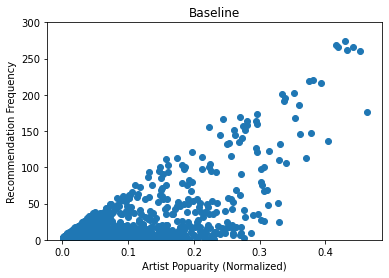

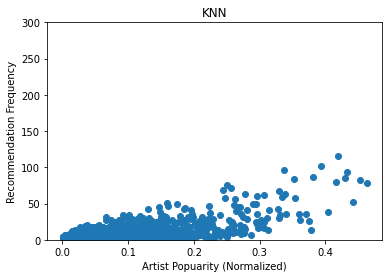

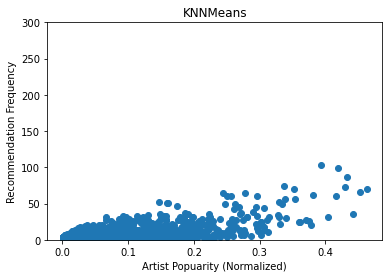

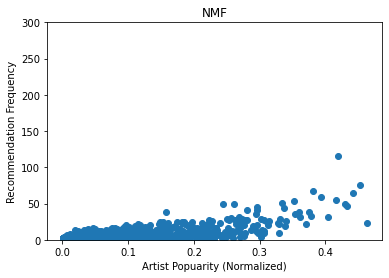

In [26]:
#Create graphs of  the correlation of artist popularity and recommendation frequency
alg_names = ['Baseline', 'KNN', 'KNNMeans', 'NMF']

for i in range(len(alg_names)):
    plot.figure()
    plot.plot(normalized_artist_dist, alg_recommendations[i], 'o')
    plot.xlabel("Artist Popuarity (Normalized)")
    plot.ylabel("Recommendation Frequency")
    plot.title(alg_names[i])
    plot.ylim([0,300])
    plot.show()
    

In [27]:
#Computes change in GAP for each RecSys alg
delta_gap_low_list = []
delta_gap_medium_list = []
delta_gap_high_list = []
for i in range(len(low_gap_r_list)):
    delta_gap_low = ((low_gap_r_list[i] - low_gap_p) / low_gap_p)
    delta_gap_medium = ((medium_gap_r_list[i] - medium_gap_p) / medium_gap_p)
    delta_gap_high = ((high_gap_r_list[i] - high_gap_p) / high_gap_p)
    
    delta_gap_low_list.append(delta_gap_low)
    delta_gap_medium_list.append(delta_gap_medium)
    delta_gap_high_list.append(delta_gap_high)
    
print(delta_gap_low_list[2])

print(delta_gap_medium_list[2])

print(delta_gap_high_list[2])


0.15310015211871414
0.23623848767865244
0.32524226091849673


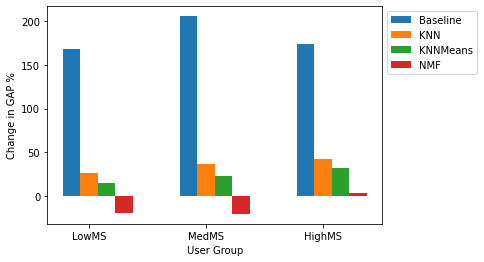

In [28]:
# Bar graph for comparing Delta GAP for each algorithm
x_labels = ["LowMS", "MedMS", "HighMS"]
width = 0.15

bar1 = [delta_gap_low_list[0] * 100, delta_gap_medium_list[0] * 100, delta_gap_high_list[0]* 100]
bar2 = [delta_gap_low_list[1] * 100, delta_gap_medium_list[1] * 100, delta_gap_high_list[1] * 100]
bar3 = [delta_gap_low_list[2] * 100, delta_gap_medium_list[2] * 100, delta_gap_high_list[2] * 100]
bar4 = [delta_gap_low_list[3] * 100, delta_gap_medium_list[3] * 100, delta_gap_high_list[3] * 100]

x1 = np.arange(3) #low/md/and high
x2 = [i+width for i in x1]
x3 = [i+width for i in x2]
x4 = [i+width for i in x3]
plot.bar(x1, bar1, width = 0.15, label ="Baseline")
plot.bar(x2, bar2, width = 0.15, label ="KNN")
plot.bar(x3, bar3, width = 0.15, label ="KNNMeans")
plot.bar(x4, bar4, width = 0.15, label ="NMF")

plot.xlabel("User Group")
plot.ylabel("Change in GAP %")
plot.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=1)
plot.xticks(x1 + width, x_labels)
plot.show()

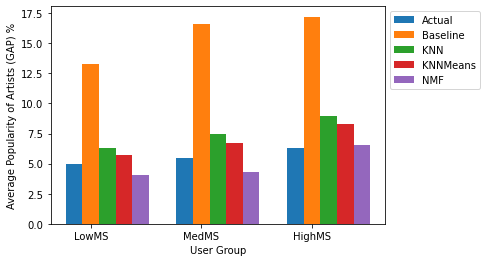

In [29]:
# bar graph comparing the GAP of each alg + the actual GAP on the dataset
x_labels = ["LowMS", "MedMS", "HighMS"]
bar1 = [low_gap_p * 100, medium_gap_p * 100, high_gap_p * 100]
bar2 = [low_gap_r_list[0] * 100, medium_gap_r_list[0] * 100, high_gap_r_list[0] * 100]
bar3 = [low_gap_r_list[1] * 100, medium_gap_r_list[1] * 100, high_gap_r_list[1] * 100]
bar4 = [low_gap_r_list[2] * 100, medium_gap_r_list[2] * 100, high_gap_r_list[2] * 100]
bar5 = [low_gap_r_list[3] * 100, medium_gap_r_list[3] * 100, high_gap_r_list[3] * 100]

x1 = np.arange(3) #low/md/and high
x2 = [i+width for i in x1]
x3 = [i+width for i in x2]
x4 = [i+width for i in x3]
x5 = [i+width for i in x4]
plot.bar(x1, bar1, width = 0.15, label ="Actual")
plot.bar(x2, bar2, width = 0.15, label ="Baseline")
plot.bar(x3, bar3, width = 0.15, label ="KNN")
plot.bar(x4, bar4, width = 0.15, label ="KNNMeans")
plot.bar(x5, bar5, width = 0.15, label ="NMF")

plot.xlabel("User Group")
plot.ylabel("Average Popularity of Artists (GAP) %")
plot.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=1)
plot.xticks(x1 + width, x_labels)
plot.show()